#Import Packages

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Download dataset

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-01-11 00:21:03--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2021-01-11 00:21:03 (79.5 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



#Load and visualiz dataset

In [ ]:
#Function to plot the dataset
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

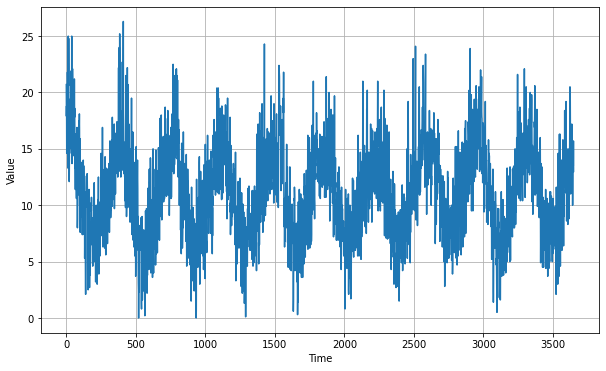

In [ ]:
#Read data from the csv file
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

#Plot the trend
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

#Data pre-processing

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

#Model Design

In [ ]:
#Set some random seeds to recreate the same results
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#Hyperparameters
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

#CNN and LSTM hybrid architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#Set a learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#Train the model and record the learning rate
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 9s 32ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 0s 28ms/step - loss: 30.7698 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 0s 30ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 0s 26ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 0s 30ms/step - loss: 24.0420 - mae: 24.5384
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 0s 30ms/step - loss: 18.2363 - mae: 18.7317
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

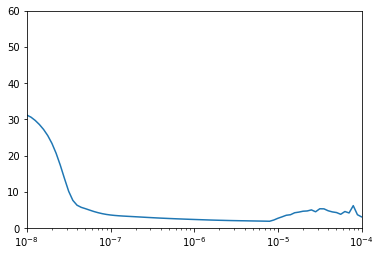

In [ ]:
#Plot loss against learning rate to see which learning rate is performing better
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

##Set the optimal learning rate

In [ ]:
#Set some random seeds to recreate the same results
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#Get the dataset
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

#Re-design the same model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


#Compile the model and set the optimal learning rate
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#Model training
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 15ms/step - loss: 15.8471 - mae: 16.3395
Epoch 2/150
25/25 [==============================] - 1s 16ms/step - loss: 2.9319 - mae: 3.4000
Epoch 3/150
25/25 [==============================] - 0s 15ms/step - loss: 2.0154 - mae: 2.4716
Epoch 4/150
25/25 [==============================] - 1s 16ms/step - loss: 1.9115 - mae: 2.3667
Epoch 5/150
25/25 [==============================] - 0s 15ms/step - loss: 1.8753 - mae: 2.3297
Epoch 6/150
25/25 [==============================] - 1s 16ms/step - loss: 1.8384 - mae: 2.2917
Epoch 7/150
25/25 [==============================] - 1s 16ms/step - loss: 1.8144 - mae: 2.2667
Epoch 8/150
25/25 [==============================] - 0s 16ms/step - loss: 1.7895 - mae: 2.2405
Epoch 9/150
25/25 [==============================] - 1s 16ms/step - loss: 1.7727 - mae: 2.2239
Epoch 10/150
25/25 [==============================] - 1s 16ms/step - loss: 1.7409 - mae: 2.1911
Epoch 11/150
25/25 [===========================

#Model Evaluation

In [ ]:
#Perform forecast on test data
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

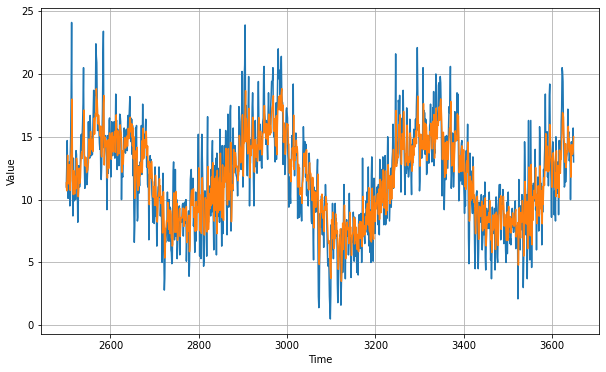

In [ ]:
#Visualize the true and forecasted data
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
#Calculate model mean absolute error
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796206